In [25]:
import pandas as pd
import numpy as np
import re
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter("ignore", UserWarning)
from collections import Counter
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import pyLDAvis.gensim
import pickle 
import pyLDAvis

### Read CSV file
data = pd.read_csv('reviews.csv',low_memory = False)
# print(data)
# data = data.drop(columns=['id', 'name', 'asins', 'brand','categories', 'keys', 'manufacturer'], axis=1).sample(100)
data = data.drop(columns=['id', 'name', 'asins', 'brand','categories', 'keys', 'manufacturer'], axis=1).sample(100)
# print(data['Text'])

data['Text'] = \
data['Text'].map(lambda x: re.sub('[,\.!?]', '', x))# Convert the titles to lowercase
data['Text'] = \
data['Text'].map(lambda x: x.lower())# Print out the first rows of papers
# data['Text'].head()
# print(data['Text'])


[nltk_data] Downloading package stopwords to /home/harsh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = data.Text.values.tolist()
data_words = list(sent_to_words(data))# remove stop words
data_words = remove_stopwords(data_words)
# print(data_words[:1][0][:30])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.038*"friendly" + 0.038*"gift" + 0.035*"user" + 0.031*"stream" + '
  '0.026*"install" + 0.024*"youtube" + 0.022*"provide" + 0.020*"think" + '
  '0.017*"streaming" + 0.017*"table"'),
 (1,
  '0.088*"price" + 0.067*"kindle" + 0.061*"great" + 0.060*"tablet" + '
  '0.035*"light" + 0.029*"game" + 0.027*"want" + 0.026*"year" + '
  '0.025*"purchase" + 0.025*"device"'),
 (2,
  '0.033*"amazon" + 0.031*"video" + 0.030*"option" + 0.028*"little" + '
  '0.025*"look" + 0.025*"life" + 0.023*"screen" + 0.023*"setup" + 0.022*"sale" '
  '+ 0.022*"make"'),
 (3,
  '0.080*"time" + 0.051*"music" + 0.042*"work" + 0.039*"well" + 0.037*"first" '
  '+ 0.035*"ask" + 0.034*"go" + 0.028*"feature" + 0.028*"find" + '
  '0.028*"thing"'),
 (4,
  '0.080*"alexa" + 0.058*"nice" + 0.051*"even" + 0.043*"like" + '
  '0.032*"command" + 0.031*"listen" + 0.030*"simple" + 0.029*"functionality" + '
  '0.025*"useful" + 0.022*"request"'),
 (5,
  '0.117*"buy" + 0.053*"book" + 0.040*"read" + 0.040*"long" + 0.031*"battery" '


In [27]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
print(df_dominant_topic.head(10))

doc_lens = [len(d) for d in df_dominant_topic.Text]


   Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             8.0              0.8714   
1            1             3.0              0.9331   
2            2             2.0              0.9100   
3            3             1.0              0.9308   
4            4             8.0              0.9150   
5            5             6.0              0.9308   
6            6             1.0              0.9526   
7            7             1.0              0.9357   
8            8             3.0              0.8473   
9            9             6.0              0.9550   

                                                                  Keywords  \
0                 easy, love, get, fire, set, tv, prime, son, amazon, fast   
1            time, music, work, well, first, ask, go, feature, find, thing   
2     amazon, video, option, little, look, life, screen, setup, sale, make   
3  price, kindle, great, tablet, light, game, want, year, purchase, device   
4              

In [28]:
doc_lens = [len(d) for d in df_dominant_topic.Text]
# print(doc_lens)
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
print(sent_topics_sorteddf_mallet.head(10))

   Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.7100   
1        1.0              0.9526   
2        2.0              0.9100   
3        3.0              0.9331   
4        4.0              0.6938   
5        5.0              0.8500   
6        6.0              0.9550   
7        7.0              0.6500   
8        8.0              0.9150   
9        9.0              0.6776   

                                                                           Keywords  \
0  friendly, gift, user, stream, install, youtube, provide, think, streaming, table   
1           price, kindle, great, tablet, light, game, want, year, purchase, device   
2              amazon, video, option, little, look, life, screen, setup, sale, make   
3                     time, music, work, well, first, ask, go, feature, find, thing   
4  alexa, nice, even, like, command, listen, simple, functionality, useful, request   
5                   buy, book, read, long, battery, never, room, say, several, ab

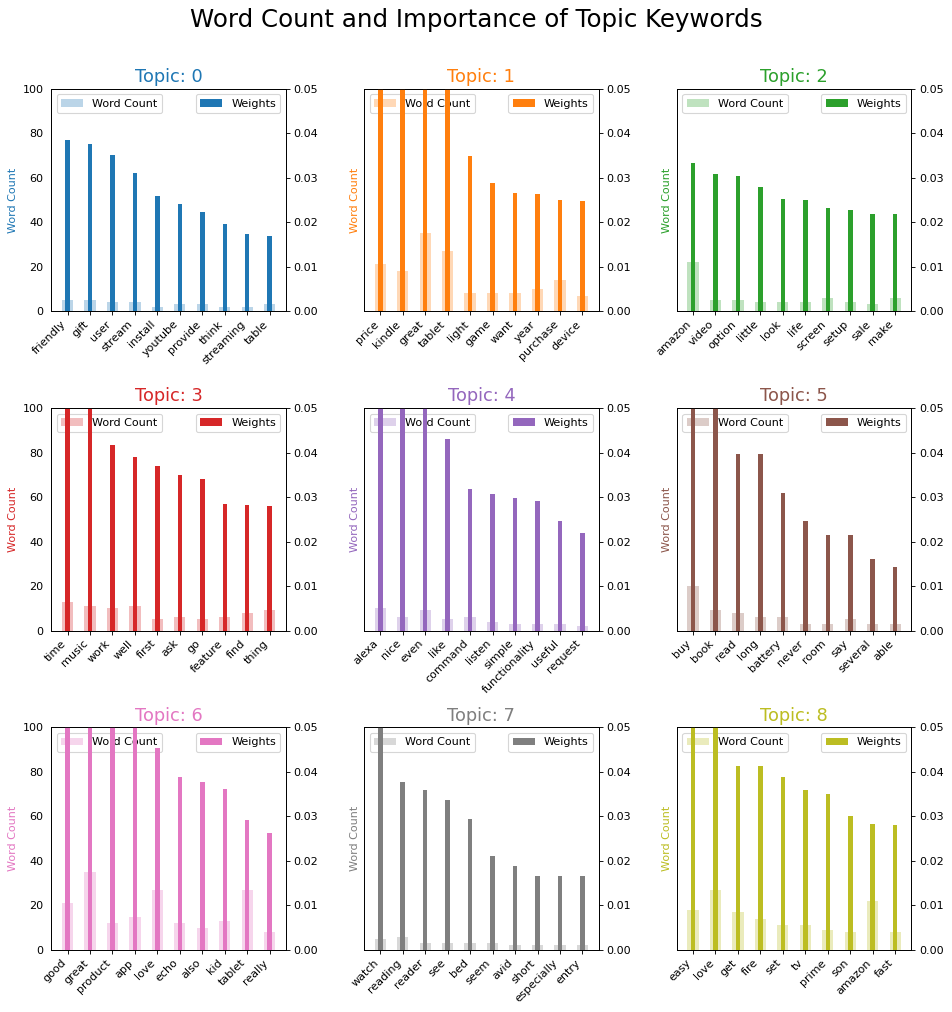

In [33]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])      
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3,3, figsize=(12,12), sharey=True, dpi=80)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.050); ax.set_ylim(0, 100)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=45, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()


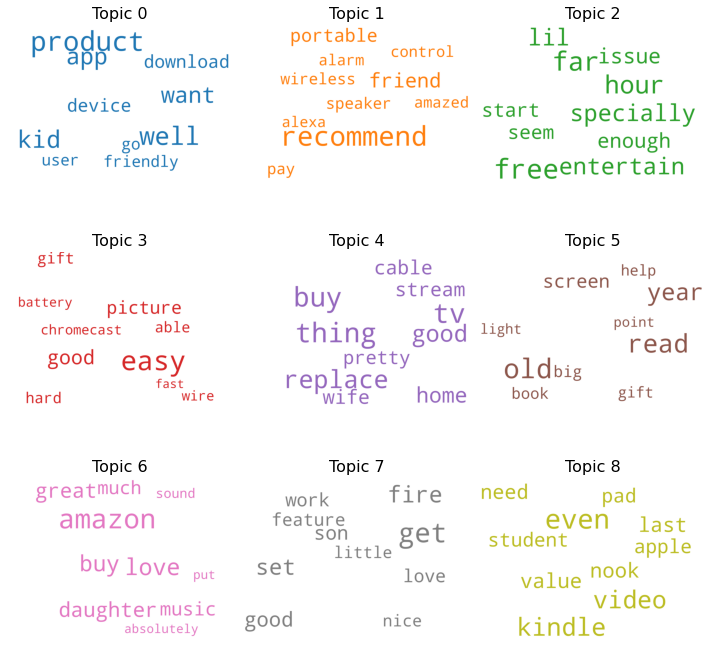

In [21]:
# 1. Wordcloud of Top N words in each topic


cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [22]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.248215  0.065759       1        1  16.488918
6     -0.176818  0.032987       2        1  13.404917
7     -0.011407 -0.193998       3        1  13.195290
0      0.093741  0.182803       4        1  11.665538
3      0.051357 -0.149053       5        1   9.310907
4     -0.003507 -0.051473       6        1   9.096143
5      0.096206  0.016308       7        1   8.605532
8      0.105721  0.071586       8        1   8.283365
2      0.041894  0.014952       9        1   5.073850
1      0.051028  0.010129      10        1   4.875541, topic_info=        Term       Freq      Total Category  logprob  loglift
8      great  34.000000  34.000000  Default  30.0000  30.0000
48    tablet  22.000000  22.000000  Default  29.0000  29.0000
75      easy  15.000000  15.000000  Default  28.0000  28.0000
32    amazon  17.000000  17.000000  Default  27.0000  27.0000
63       old  10.000000  10.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
231    sharp   0.349448   0.977167  Topic10  -5.1379   1.9926
217    class   0.349313   0.977117  Topic10  -5.1383   1.9923
218  college   0.349313   0.977117  Topic10  -5.1383   1.9923
219  compact   0.349313   0.977117  Topic10  -5.1383   1.9923
26      fast   0.648699   3.581635  Topic10  -4.5193   1.3123

[349 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
384       5  0.952053        able
143       2  0.891393  absolutely
386       3  0.942434     account
488       5  0.925149    accurate
79        1  0.805497    actually
...     ...       ...         ...
332       8  0.605032        wish
20        1  0.555975        work
20        3  0.397125        work
290       4  0.475023       worth
99        7  0.877124        year

[299 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 8, 1, 4, 5, 6, 9, 3, 2])

In [23]:

#Vectorize data
vectorizer = CountVectorizer(analyzer='word',lowercase=True)
data_vectorized = vectorizer.fit_transform(data)

#Get several search params and learning decays for the LDA model
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .6, .7, .8, .9]}
lda = LatentDirichletAllocation(learning_method='online', learning_offset=10.0, random_state=0)
 
#Use GridSearchCV in order to run through to get the best param
#according to Log Likelihood and and Model Perplexity
model = GridSearchCV(lda, param_grid=search_params)
model.fit(data_vectorized)
best_lda_model = model.best_estimator_

print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -5670.296856662608
Model Perplexity:  651.8020664203385
